# Filling the Blanks: Enhancing Vulnerability Assessment in Hosts

##### Mohammad Y. Abdullaha, Amirreza Talebia, Theodore T. Allenb, John McCartya
Integrated Systems Engineering , The Ohio State University, Columbus, Ohio, USA


##### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import json
import re
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Data

### 1.2 Data Import

In [2]:
# loop the folder to create dfs from Excel files - Data needs to be on the same file as of this code and have the same name.
for j in range(0, 2):
  for i in range(12):
    file_name = f"NessusResults_201{j+4}-0{i+1}.xlsx"
    
    if os.path.isfile(file_name):
      print(f"{file_name} exists")
      # create dfs
      exec(f"df{j+4}{i+1} = pd.read_excel('{file_name}')")
    else:
      print(f"{file_name} does not exist")

NessusResults_2014-01.xlsx exists
NessusResults_2014-02.xlsx does not exist
NessusResults_2014-03.xlsx exists
NessusResults_2014-04.xlsx exists
NessusResults_2014-05.xlsx exists
NessusResults_2014-06.xlsx exists
NessusResults_2014-07.xlsx exists
NessusResults_2014-08.xlsx exists
NessusResults_2014-09.xlsx exists
NessusResults_2014-010.xlsx exists
NessusResults_2014-011.xlsx exists
NessusResults_2014-012.xlsx exists
NessusResults_2015-01.xlsx exists
NessusResults_2015-02.xlsx exists
NessusResults_2015-03.xlsx exists
NessusResults_2015-04.xlsx exists
NessusResults_2015-05.xlsx exists
NessusResults_2015-06.xlsx exists
NessusResults_2015-07.xlsx exists
NessusResults_2015-08.xlsx exists
NessusResults_2015-09.xlsx exists
NessusResults_2015-010.xlsx exists
NessusResults_2015-011.xlsx does not exist
NessusResults_2015-012.xlsx does not exist


In [3]:
# Concatenate all DataFrames along the rows (axis=0)
all_df = pd.concat([df41, df43, df44, df45, df46, df47, df48, df49, df410, df411, df412, df51, df52, df53, df54, df55, df56, df57, df58, df59, df510], axis=0)

### 1.3 Data Preporcessing

#### 1.3.1 Cleaning

In [5]:
# Drop Data - Round 1 - John and Make Sense Drop - This drop happened to remove the duplication
df = all_df.drop(['id', 'port_number', 'scan_job_id', 'bid','service_name', 'protocol', 'synopsis', 'description', 'solution',  'first_seen', 'ip_scan_started_at', 'ip_scan_finished_at', 'scanner_group_id', 'peer_has_restricted_data', 'osvdb', 'cwe', 'scheduled_resolution_date', 'risk_acceptance_expiration', 'peer_is_high_avail_system', 'resolution_status', 'peer_is_critical_system', 'nessus_plugin_id', 'nessus_plugin_name', 'nessus_plugin_category'], axis=1)

# drop duplicate rows and print the result
df = df.drop_duplicates()

# Drop Data - Round 2 - John and Make Sense Drop
df_prep = df.drop(['numeric_risk_factor', 'severity', 'is_critical_server', 'created_on'], axis=1)

# To show all columns and rows
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Convert some data in the "created_on_date" feature to be a datetime type 
df_prep.loc[:, 'created_on_date'] = pd.to_datetime(df_prep['created_on_date'])

# Sort 
df_prep = df_prep.sort_values('created_on_date')

# Remove "{" , "}" in org_id_md5_array
df_prep['org_id_md5_array'] = df_prep['org_id_md5_array'].str.replace('{', '', regex=False).str.replace('}', '', regex=False)

# Nan to .... 
df_prep['cve'].fillna(value= "Non", inplace=True)
df_prep['operating_system'].fillna(value= "Unknown", inplace=True)
df_prep['host_system_type'].fillna(value= "Undefined", inplace=True)
df_prep['org_id_md5_array'].fillna(value= "Undefined", inplace=True)

# For all other "Nan" for now we will give them a value of " "
df_prep.fillna(value= " ", inplace=True)

# Type formate 
df_prep['host_system_type'] = df_prep['host_system_type'].replace('general_purpose', 'general-purpose')

In [6]:
# Group By - Merging rows that we beleive belong to the same scans
df_prep = df_prep.groupby(['ip_address_md5', 'created_on_date', 'operating_system', 'host_system_type']).agg(
    {'cve': 'sum',
     'cvss_base_score': 'max',
     'org_id_md5_array': 'max'
     }).reset_index()

# Sort by date
df_prep = df_prep.sort_values('created_on_date')
# Reset index
df_prep = df_prep.reset_index(drop=False)

### 1.4 Data Exploration  

In [7]:
# Summary
df_prep['cvss_base_score'].describe()

count    474254.000000
mean          5.170181
std           1.883224
min           0.000000
25%           2.600000
50%           6.400000
75%           6.400000
max          10.000000
Name: cvss_base_score, dtype: float64

In [8]:
df_prep.head()

,index,ip_address_md5,created_on_date,operating_system,host_system_type,cve,cvss_base_score,org_id_md5_array
0,359299,c284e42082135ccf7696df15639f9812,2014-01-08,Unknown,Undefined,"CVE-2002-1700,CVE-2003-1543,CVE-2005-2453,CVE-...",5.0,9ae82c26134ecd4981bda3c252fc1acf
1,448753,f2b42d7b762e1cf3adc05e1e9e3155f5,2014-01-08,Unknown,Undefined,Non,2.6,"e6b851f75f784b4d0123f1d217781604,3ee03b285337e..."
2,30891,110156548e441dd0f0325d6e8150d118,2014-01-08,Unknown,Undefined,NonNon,6.4,"e6b851f75f784b4d0123f1d217781604,3ee03b285337e..."
3,465589,fb8e15909b408780152550bb1d5a351e,2014-01-08,Unknown,Undefined,"CVE-2013-2566CVE-2013-1862,CVE-2013-1896CVE-20...",6.9,9ae82c26134ecd4981bda3c252fc1acf
4,202487,6d66e41ab92157d3eb4deb70ba56386b,2014-01-08,Unknown,Undefined,NonNonCVE-2013-2566CVE-2013-2566NonNonNon,7.5,dcddb75469b4b4875094e14561e573d8


#### 1.4.1 Visulization 

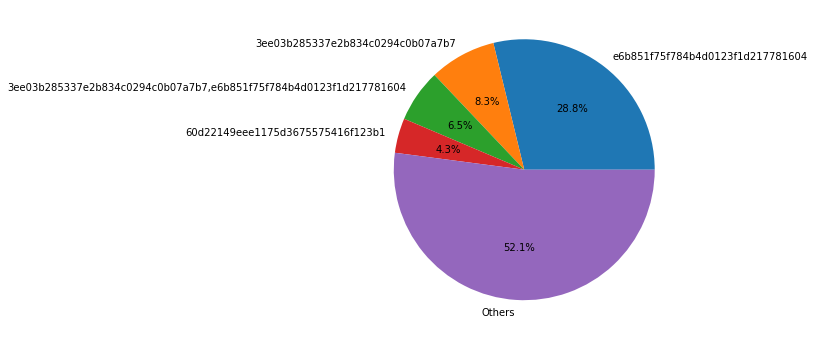

In [10]:
# Count the occurrences of each category and calculate the percentages
os_counts = df_prep['org_id_md5_array'].value_counts()
percentages = (os_counts / os_counts.sum()) * 100

# Filter out the categories with less than 4% and sum them up
other_count = os_counts[percentages < 4].sum()
other_percentage = percentages[percentages < 4].sum()

# Filter the counts and labels to include only those above 4%
filtered_counts = os_counts[percentages >= 4]
filtered_labels = os_counts.index[percentages >= 4]

# Append 'other' category
filtered_counts = filtered_counts.append(pd.Series([other_count], index=['Others']))
filtered_labels = filtered_labels.tolist() + ['Others']

# Create a custom autopct function
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(filtered_counts, labels = filtered_labels, autopct=custom_autopct)

plt.show()


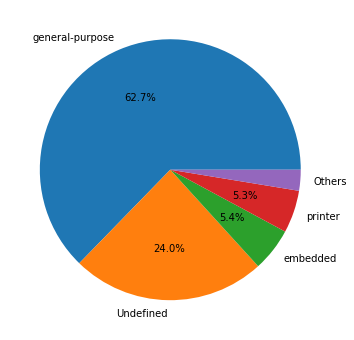

In [11]:
# Count the occurrences of each category and calculate the percentages
os_counts = df_prep['host_system_type'].value_counts()
percentages = (os_counts / os_counts.sum()) * 100

# Filter out the categories with less than 4% and sum them up
other_count = os_counts[percentages < 4].sum()
other_percentage = percentages[percentages < 4].sum()

# Filter the counts and labels to include only those above 4%
filtered_counts = os_counts[percentages >= 4]
filtered_labels = os_counts.index[percentages >= 4]

# Append 'other' category
filtered_counts = filtered_counts.append(pd.Series([other_count], index=['Others']))
filtered_labels = filtered_labels.tolist() + ['Others']

# Create a custom autopct function
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(filtered_counts, labels = filtered_labels, autopct=custom_autopct)

plt.show()


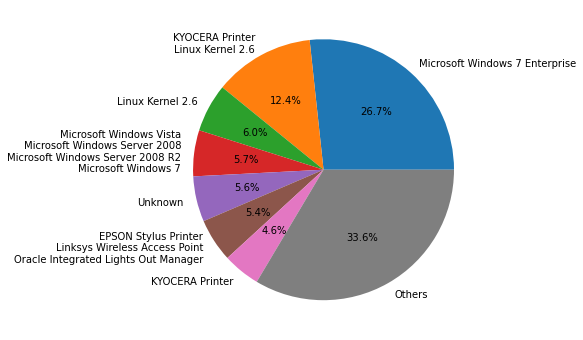

In [12]:
# Count the occurrences of each category and calculate the percentages
os_counts = df_prep['operating_system'].value_counts()
percentages = (os_counts / os_counts.sum()) * 100

# Filter out the categories with less than 4% and sum them up
other_count = os_counts[percentages < 4].sum()
other_percentage = percentages[percentages < 4].sum()

# Filter the counts and labels to include only those above 4%
filtered_counts = os_counts[percentages >= 4]
filtered_labels = os_counts.index[percentages >= 4]

# Append 'other' category
filtered_counts = filtered_counts.append(pd.Series([other_count], index=['Others']))
filtered_labels = filtered_labels.tolist() + ['Others']

# Create a custom autopct function
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct >= 4 else ''

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(filtered_counts, labels = filtered_labels, autopct=custom_autopct)

plt.show()

Number of outliers: 0
precentage of outlaiers:  0.0


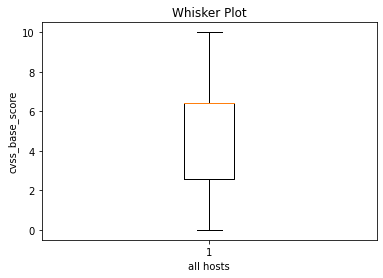

In [13]:
# Check if there are any outliers bfore merging
# Calculate Q1, Q3, and IQR
Q1 = df_prep['cvss_base_score'].quantile(0.25)
Q3 = df_prep['cvss_base_score'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the number of outliers
num_outliers = len(df_prep[(df_prep['cvss_base_score'] < lower_bound) | (df_prep['cvss_base_score'] > upper_bound)])
print("Number of outliers:", num_outliers)
print("precentage of outlaiers: ", num_outliers/len(df_prep) * 100)
# Create a figure and axis object
fig, ax = plt.subplots()

# Create a whisker plot
ax.boxplot(df_prep['cvss_base_score'])

# Set the title and axis labels
ax.set_title('Whisker Plot')
ax.set_xlabel('all hosts')
ax.set_ylabel('cvss_base_score')

# Display the plot
plt.show()

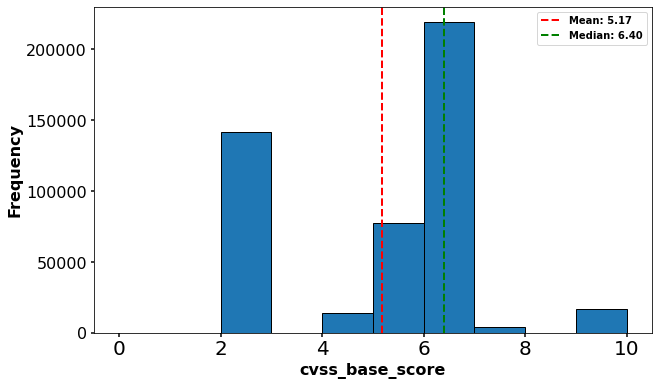

In [14]:
# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# Create a histogram
ax.hist(df_prep['cvss_base_score'], bins=10, edgecolor='black')

# Calculate mean and median
mean = df_prep['cvss_base_score'].mean()
median = df_prep['cvss_base_score'].median()

# Add vertical lines for mean and median
ax.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
ax.axvline(median, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median:.2f}')

# Set the title and axis labels
ax.set_xlabel('cvss_base_score', fontsize=16, weight='bold')
ax.set_ylabel('Frequency', fontsize=16, weight='bold')

# Modify the tick label sizes and rotate x-axis labels
ax.tick_params(axis='x', labelrotation=0, labelsize=20, width=1.5)
ax.tick_params(axis='y', labelsize=16, width=1.5)

# Add a legend
ax.legend(prop={'weight':'bold'})

# Display the plot
plt.show()


In [15]:
# Initialize a dictionary to hold counts
count_dict = {}

# Loop through the range
for i in range(10):
    count_dict[f'{i} to {i+1}'] = df_prep[(df_prep['cvss_base_score'] > i) & (df_prep['cvss_base_score'] <= i+1)].shape[0]

# Print the counts
for key, value in count_dict.items():
    print(f'Count of records from {key}: {value}')

Count of records from 0 to 1: 0
Count of records from 1 to 2: 0
Count of records from 2 to 3: 142094
Count of records from 3 to 4: 649
Count of records from 4 to 5: 46725
Count of records from 5 to 6: 44088
Count of records from 6 to 7: 219290
Count of records from 7 to 8: 4441
Count of records from 8 to 9: 94
Count of records from 9 to 10: 16830


In [16]:
dfs_type = {}

for host_type in df_prep['host_system_type'].unique():
    df = df_prep[df_prep['host_system_type'] == host_type]
    dfs_type[f'rows_type_{host_type}'] = df

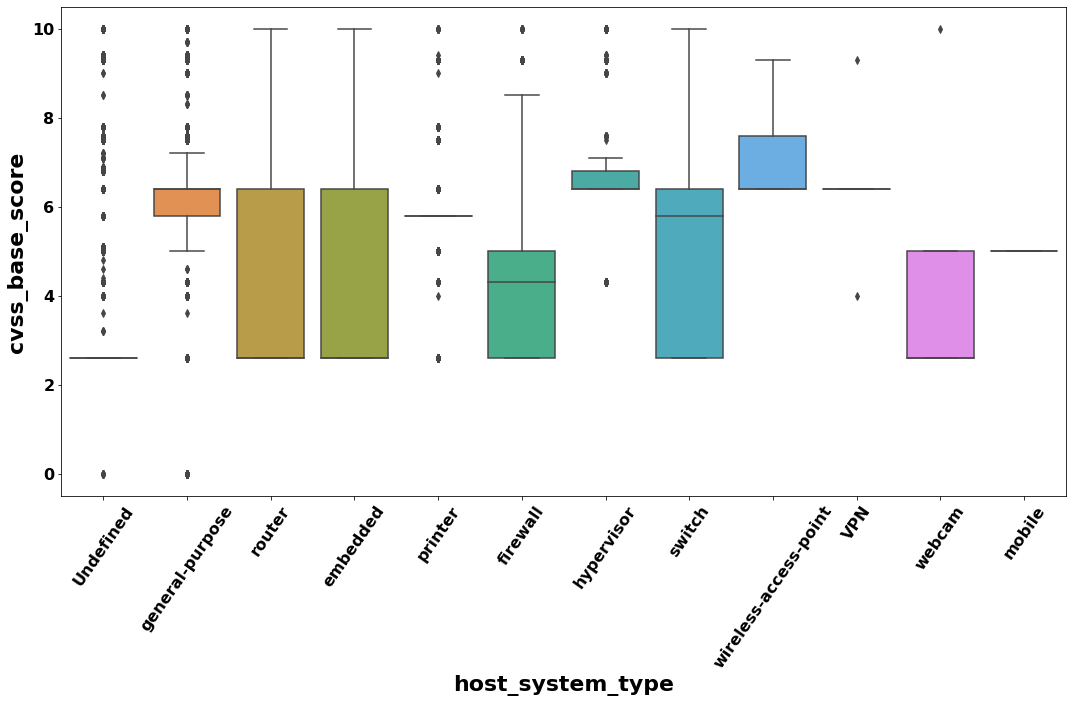

In [17]:
# Concatenate the dataframes
df_concat = pd.concat(dfs_type)

# Set the size of the plot
plt.figure(figsize=(18, 9))

# Plot the boxplot using seaborn
sns.boxplot(x="host_system_type", y="cvss_base_score", data=df_prep)

# Modify the label sizes
plt.xlabel('host_system_type', fontsize=22, weight='bold')  # Change the value of fontsize to whatever you need
plt.ylabel('cvss_base_score', fontsize=22, weight='bold')  # Change the value of fontsize to whatever you need

# Modify the tick label sizes and rotate x-axis labels
plt.xticks(fontsize=16, rotation=55, weight='bold')  # Change the value of fontsize to whatever you need and adjust rotation
plt.yticks(fontsize=16, weight='bold')  # Change the value of fontsize to whatever you need



# Show the plot
plt.show()


#### 1.4.2 Feature Engineering

In [19]:
# We need to have string formate 
data_to_process = df_prep['org_id_md5_array'].unique().astype(str)

# flatten a list of lists using "chain function" 
from itertools import chain
result2 = list(chain.from_iterable([x.split(',') for x in data_to_process]))

# Convert from list to df - to ease the working with
the_list =  pd.DataFrame(result2, columns=['org_id'])

# Remove Dublicated Records
the_list_2 = the_list.drop_duplicates(subset=None, keep='first', inplace=False)

# Create new column for every organization - value of 1 if the host is in that department, o/w value of 0
for val in the_list_2['org_id']:
    column_name = f"orgid# {val[:4]}"
    df_prep[column_name] = df_prep['org_id_md5_array'].astype(str).apply(lambda x: 1 if val in x else 0)

# Drop 
df_prep = df_prep.drop(['org_id_md5_array'], axis=1)

# drop the 'Undefined' column, if it exists
if 'orgid# Undefined' in df_prep.columns:
    df_prep = df_prep.drop('orgid# Undefined', axis=1)


New feature - Add cvss-base-score to the previous preiod

In [20]:
# Shit csvv score to the previous preiod. 
#(fillna is to make the 1st row = to the same value since there is no value to shift from)
df_prep['last_cvss_base_score'] = df_prep.groupby([
    'ip_address_md5', 'operating_system', 'host_system_type'])['cvss_base_score'].shift(1).fillna(df_prep['cvss_base_score'])

New features - Some significant vulns + a binary feature (whether this scan shows at least one SCV in this host)

In [21]:
# Vulnerabilities that had significant impacts on the security landscape. Based on GPT-4. 
Heartbleed = 'CVE-2014-0160' 
Shellshock = 'CVE-2014-6271'
Poodle = 'CVE-2014-3566'
FREAK = 'CVE-2015-0204'
Ghost = 'CVE-2015-0235'
JASBUG = 'CVE-2015-0008'
Logjam = 'CVE-2015-4000'


# check if a certin, defined vuln appears in hosts and add a value of 1 to its new column
df_prep['Heartbleed'] = df_prep['cve'].apply(lambda x: 1 if Heartbleed in x else 0)
df_prep['Shellshock'] = df_prep['cve'].apply(lambda x: 1 if Shellshock in x else 0)
df_prep['Poodle'] = df_prep['cve'].apply(lambda x: 1 if Poodle in x else 0)
df_prep['FREAK'] = df_prep['cve'].apply(lambda x: 1 if FREAK in x else 0)
df_prep['Ghost'] = df_prep['cve'].apply(lambda x: 1 if Ghost in x else 0)
df_prep['JASBUG'] = df_prep['cve'].apply(lambda x: 1 if JASBUG in x else 0)
df_prep['Logjam'] = df_prep['cve'].apply(lambda x: 1 if Logjam in x else 0)


print("Heartbleed: ", df_prep['Heartbleed'].sum()," - ", df_prep['Heartbleed'].sum()/len(df_prep) * 100," % ")
print("Shellshock: ", df_prep['Shellshock'].sum()," - ", df_prep['Shellshock'].sum()/len(df_prep)* 100," % ")
print("Poodle: ", df_prep['Poodle'].sum()," - ", df_prep['Poodle'].sum()/len(df_prep)* 100," % ")
print("FREAK: ", df_prep['FREAK'].sum()," - ", df_prep['FREAK'].sum()/len(df_prep)* 100," % ")
print("Ghost: ", df_prep['Ghost'].sum()," - ", df_prep['Ghost'].sum()/len(df_prep)* 100," % ")
print("JASBUG: ", df_prep['JASBUG'].sum()," - ", df_prep['JASBUG'].sum()/len(df_prep)* 100," % ")
print("Logjam: ", df_prep['Logjam'].sum()," - ", df_prep['Logjam'].sum()/len(df_prep)* 100," % ")


# List of vulnerability columns 
vulnerability_columns = ['Heartbleed', 'Shellshock', 'Poodle', 'FREAK', 'Ghost', 'JASBUG', 'Logjam']

# Create a new column 'super_vuln', is 1 if any of the vulnerability columns have a value of 1, otherwise 0
df_prep['super_vuln'] = df_prep[vulnerability_columns].any(axis=1).astype(int)


Heartbleed:  564  -  0.11892361477183114  % 
Shellshock:  58  -  0.012229733433982632  % 
Poodle:  35535  -  7.49282030304436  % 
FREAK:  6876  -  1.4498559843459413  % 
Ghost:  127  -  0.026778899070961974  % 
JASBUG:  3209  -  0.6766416308560391  % 
Logjam:  3939  -  0.8305675861458205  % 


In [22]:
print("super_vuln: ", df_prep['super_vuln'].sum()," - That means there are  ", df_prep['super_vuln'].sum()/len(df_prep) * 100,"%   hosts have at least one super critical vuln. ")

super_vuln:  38150  - That means there are   8.044212594938577 %   hosts have at least one super critical vuln. 


Encoding features

In [23]:
# Encode some clumns if we are choosing Logistic Regression as a model. 
from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
le1 = LabelEncoder()
le2 = LabelEncoder()

# fit and transform the categorical column
df_prep['operating_system'] = le1.fit_transform(df_prep['operating_system'])
df_prep['host_system_type'] = le2.fit_transform(df_prep['host_system_type'])

print('operating_system: ', len(df_prep['operating_system'].unique()))
print('host_system_type: ', len(df_prep['host_system_type'].unique()))

operating_system:  632
host_system_type:  12


In [24]:
# Get the list of encoded values and their corresponding original values
operating_system_mapping = dict(zip(le1.classes_, range(len(le1.classes_))))
host_system_type_mapping = dict(zip(le2.classes_, range(len(le2.classes_))))

#print("Operating System Mapping:", operating_system_mapping)
print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("Host System Type Mapping:", host_system_type_mapping)


 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Host System Type Mapping: {'Undefined': 0, 'VPN': 1, 'embedded': 2, 'firewall': 3, 'general-purpose': 4, 'hypervisor': 5, 'mobile': 6, 'printer': 7, 'router': 8, 'switch': 9, 'webcam': 10, 'wireless-access-point': 11}


Extra Graph

In [25]:
cleaned_df = df_prep.dropna()

In [29]:
cleaned_df_2 = cleaned_df
cleaned_df_2['year_month'] = cleaned_df['created_on_date'].dt.to_period('M')

cleaned_df_2['year_month'].value_counts().sort_index()

cleaned_df_2_few = cleaned_df_2[['ip_address_md5', 'operating_system', 'year_month', 'host_system_type', 'cvss_base_score', 'super_vuln']]

In [32]:
# Convert 'year_month' to a datetime object
cleaned_df_2_few['year_month'] = cleaned_df_2_few['year_month'].dt.to_timestamp()

# Group by 'year_month'
grouped = cleaned_df_2_few.groupby(cleaned_df_2_few['year_month'])

# Prepare data for each plot
records_per_month = grouped.size()
unique_ips_per_month = grouped['ip_address_md5'].nunique()
sum_super_vuln_per_month = grouped['super_vuln'].sum()
sum_cvss_base_score_per_month = grouped['cvss_base_score'].sum()


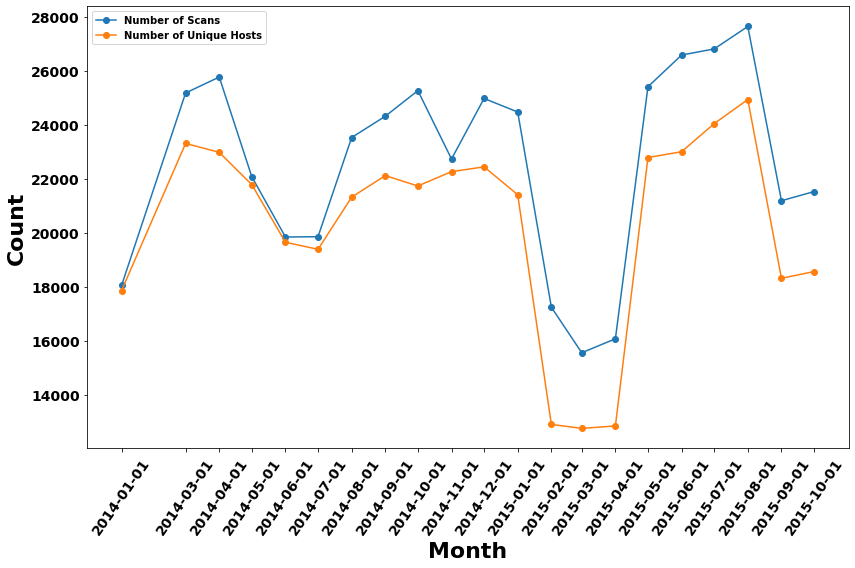

In [33]:
import matplotlib.pyplot as plt

# Creating figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot 1: the number of Hosts for every month
ax.plot(records_per_month.index, records_per_month.values, marker='o', label='Number of Scans')
ax.set_xlabel('Month', fontsize=22, weight='bold')
ax.set_ylabel('Count', fontsize=22, weight='bold')

# Plot 2: The number of unique "ip_address_md5" for every month
ax.plot(unique_ips_per_month.index, unique_ips_per_month.values, marker='o', label='Number of Unique Hosts')

# Add a legend with white text color
legend = ax.legend(prop={'weight':'bold'})

# Modify the tick label sizes and rotate x-axis labels
ax.set_xticks(records_per_month.index)  # Add this line
plt.xticks(fontsize=14, rotation=55, weight='bold')  # Change the value of fontsize to whatever you need and adjust rotation
plt.yticks(fontsize=14, weight='bold')  # Change the value of fontsize to whatever you need

# Improving layout
plt.tight_layout()
plt.show()


In [ ]:
# Run Spetrlly for more info
unique_ips_per_month
records_per_month

Create feature sets

In [34]:
# Drop created feature for th graph above "year_month"
cleaned_df  = cleaned_df.drop(['year_month'], axis=1)

# Feature sets for Predection models 
os_N_type = cleaned_df[['operating_system', 'host_system_type']]
score = cleaned_df[['last_cvss_base_score']]
orgid  = cleaned_df.drop(['index', 'ip_address_md5', 'created_on_date', 'operating_system', 'host_system_type', 'cve', 'cvss_base_score', 'Heartbleed', 'Shellshock', 'Poodle', 'FREAK', 'Ghost', 'JASBUG', 'Logjam', 'last_cvss_base_score', 'super_vuln'], axis=1)
outcome_predction = cleaned_df[['cvss_base_score']]

## 2. Models

### 2.1 Regression

Libraries needed for models

In [36]:
pip install psutil

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score  

In [41]:
import itertools
import time
import psutil
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.linear_model import Ridge


#### 2.1.1 Linear Regression

In [39]:


# Assuming os_N_type, score, orgid are your feature sets and outcome_predction is the target variable
feature_sets = [os_N_type, score, orgid]
feature_sets_names = ["os_N_type", "score", "orgid"]
y = outcome_predction

# Generate all possible non-empty combinations of the feature sets
combinations = []
combination_names = []
for r in range(1, len(feature_sets) + 1):
    for subset in itertools.combinations(range(len(feature_sets)), r):
        combinations.append(np.concatenate([feature_sets[i] for i in subset], axis=1))  # Join the feature sets along columns
        combination_names.append([feature_sets_names[i] for i in subset])  # Get the names of the feature sets

# Define your model
model = LinearRegression()

# For each combination of feature sets, train and evaluate the model
for i, X in enumerate(combinations):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Measure CPU usage before training
    cpu_percent_before = psutil.cpu_percent()

    # Start the clock
    start_time = time.time()

    # Perform cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Stop the clock
    end_time = time.time()

    # Measure CPU usage after training
    cpu_percent_after = psutil.cpu_percent()

    # Calculate elapsed time and average CPU usage during the period
    elapsed_time = end_time - start_time
    average_cpu_usage = (cpu_percent_before + cpu_percent_after) / 2.0

    print(f"Combination {i+1}: {combination_names[i]}")  # Print the names of the feature sets used
    print("Cross-validation scores: ", cv_scores)
    print("Average cross-validation score: ", np.mean(cv_scores))
    print(f"Time taken for training: {elapsed_time:.2f} seconds")
    print(f"Average CPU usage during training: {average_cpu_usage:.2f}%")

    # Fit and validate the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Print the performance metrics
    print("Test set RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
    print("Test set R2: ", r2_score(y_test, predictions))
    print("\n")


Combination 1: ['os_N_type']
Cross-validation scores:  [0.50028234 0.48965009 0.49576866 0.49172007 0.49112787]
Average cross-validation score:  0.493709804525435
Time taken for training: 0.78 seconds
Average CPU usage during training: 15.55%
Test set RMSE:  1.3434303121283522
Test set R2:  0.48989124330075917


Combination 2: ['score']
Cross-validation scores:  [0.88828245 0.88983684 0.88710353 0.8919702  0.88681387]
Average cross-validation score:  0.8888013770904901
Time taken for training: 0.17 seconds
Average CPU usage during training: 20.50%
Test set RMSE:  0.6269288555614566
Test set R2:  0.8889115233038812


Combination 3: ['orgid']
Cross-validation scores:  [  0.37348615   0.3689311    0.37670437 -10.61548714   0.36977027]
Average cross-validation score:  -1.8253190473802676
Time taken for training: 9.59 seconds
Average CPU usage during training: 17.90%
Test set RMSE:  1.4895094735474794
Test set R2:  0.3729256566855884


Combination 4: ['os_N_type', 'score']
Cross-validation 

#### 2.1.2 Ridge Regression

In [43]:
import itertools
import time
import psutil
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Assuming os_N_type, score, orgid are your feature sets and outcome_predction is the target variable

feature_sets = [os_N_type, score, orgid]
feature_sets_names = ["os_N_type", "score", "orgid"]
y = outcome_predction

# Generate all possible non-empty combinations of the feature sets
combinations = []
combination_names = []
for r in range(1, len(feature_sets) + 1):
    for subset in itertools.combinations(range(len(feature_sets)), r):
        combinations.append(np.concatenate([feature_sets[i] for i in subset], axis=1))  # Join the feature sets along columns
        combination_names.append([feature_sets_names[i] for i in subset])  # Get the names of the feature sets

# Define your model
model = Ridge()

# For each combination of feature sets, train and evaluate the model
for i, X in enumerate(combinations):
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Measure CPU usage before training
    cpu_percent_before = psutil.cpu_percent()

    # Start the clock
    start_time = time.time()

    # Perform cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Stop the clock
    end_time = time.time()

    # Measure CPU usage after training
    cpu_percent_after = psutil.cpu_percent()

    # Calculate elapsed time and average CPU usage during the period
    elapsed_time = end_time - start_time
    average_cpu_usage = (cpu_percent_before + cpu_percent_after) / 2.0

    print(f"Combination {i+1}: {combination_names[i]}")  # Print the names of the feature sets used
    print("Cross-validation scores: ", cv_scores)
    print("Average cross-validation score: ", np.mean(cv_scores))
    print(f"Time taken for training: {elapsed_time:.2f} seconds")
    print(f"Average CPU usage during training: {average_cpu_usage:.2f}%")

    # Fit and validate the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Print the performance metrics
    print("Test set RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
    print("Test set R2: ", r2_score(y_test, predictions))
    print("\n")


Combination 1: ['os_N_type']
Cross-validation scores:  [0.50028233 0.4896501  0.49576866 0.49172007 0.49112786]
Average cross-validation score:  0.4937098045318762
Time taken for training: 0.21 seconds
Average CPU usage during training: 11.80%
Test set RMSE:  1.343430310117375
Test set R2:  0.4898912448279201


Combination 2: ['score']
Cross-validation scores:  [0.88828245 0.88983684 0.88710353 0.8919702  0.88681386]
Average cross-validation score:  0.8888013770952975
Time taken for training: 0.10 seconds
Average CPU usage during training: 10.95%
Test set RMSE:  0.6269288484656736
Test set R2:  0.8889115258185516


Combination 3: ['orgid']
Cross-validation scores:  [0.37350464 0.36895729 0.37669009 0.37791493 0.36979075]
Average cross-validation score:  0.3733715409853578
Time taken for training: 3.92 seconds
Average CPU usage during training: 20.25%
Test set RMSE:  1.4895171803493246
Test set R2:  0.3729191676362814


Combination 4: ['os_N_type', 'score']
Cross-validation scores:  [0.

#### 2.1.3 Gradient Boosting Regressor

In [44]:
import itertools
import time
import psutil
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Assuming os_N_type, score, orgid are your feature sets and outcome_predction is the target variable

feature_sets = [os_N_type, score, orgid]
feature_sets_names = ["os_N_type", "score", "orgid"]
y = outcome_predction

# Generate all possible non-empty combinations of the feature sets
combinations = []
combination_names = []
for r in range(1, len(feature_sets) + 1):
    for subset in itertools.combinations(range(len(feature_sets)), r):
        combinations.append(np.concatenate([feature_sets[i] for i in subset], axis=1))  # Join the feature sets along columns
        combination_names.append([feature_sets_names[i] for i in subset])  # Get the names of the feature sets

# Define your model
model = GradientBoostingRegressor()

# For each combination of feature sets, train and evaluate the model
for i, X in enumerate(combinations):
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Measure CPU usage before training
    cpu_percent_before = psutil.cpu_percent()

    # Start the clock
    start_time = time.time()

    # Perform cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Stop the clock
    end_time = time.time()

    # Measure CPU usage after training
    cpu_percent_after = psutil.cpu_percent()

    # Calculate elapsed time and average CPU usage during the period
    elapsed_time = end_time - start_time
    average_cpu_usage = (cpu_percent_before + cpu_percent_after) / 2.0

    print(f"Combination {i+1}: {combination_names[i]}")  # Print the names of the feature sets used
    print("Cross-validation scores: ", cv_scores)
    print("Average cross-validation score: ", np.mean(cv_scores))
    print(f"Time taken for training: {elapsed_time:.2f} seconds")
    print(f"Average CPU usage during training: {average_cpu_usage:.2f}%")

    # Fit and validate the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Print the performance metrics
    print("Test set RMSE: ", np.sqrt(mean_squared_error(y_test, predictions)))
    print("Test set R2: ", r2_score(y_test, predictions))
    print("\n")


Combination 1: ['os_N_type']
Cross-validation scores:  [0.65446893 0.64960086 0.65400185 0.6549527  0.64742511]
Average cross-validation score:  0.6520898922777016
Time taken for training: 33.58 seconds
Average CPU usage during training: 12.75%
Test set RMSE:  1.1079512356256243
Test set R2:  0.6530444932446513


Combination 2: ['score']
Cross-validation scores:  [0.8981497  0.8997289  0.89694388 0.900965   0.89631145]
Average cross-validation score:  0.89841978713969
Time taken for training: 16.73 seconds
Average CPU usage during training: 12.95%
Test set RMSE:  0.5951314571323619
Test set R2:  0.8998944155199045


Combination 3: ['orgid']
Cross-validation scores:  [0.38015005 0.37366932 0.38154756 0.38156653 0.37480368]
Average cross-validation score:  0.3783474290855121
Time taken for training: 743.05 seconds
Average CPU usage during training: 13.00%
Test set RMSE:  1.4843554580082194
Test set R2:  0.3772577664876702


Combination 4: ['os_N_type', 'score']
Cross-validation scores:  

Model 7 (Gradient Boosting Regression (18 and 21) are the best. For the sake of exloraraty we will go with the model 21 which it does have all of the feature sets. To investigate all of the features and check the contribution of the 

Mean squared error:  0.34627410868817293
R-squared score: 0.90


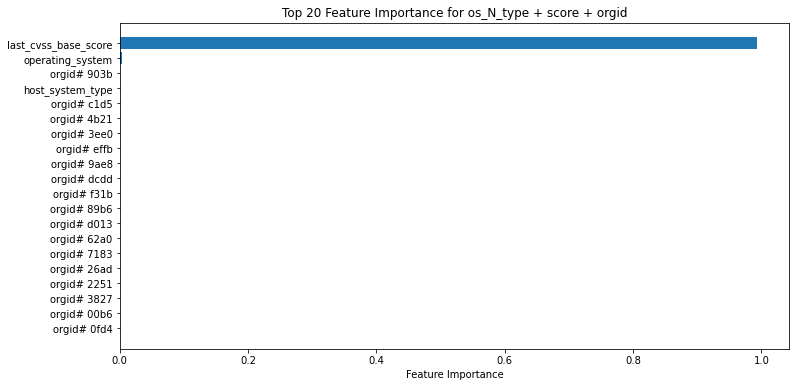

In [46]:
# Assuming os_N_type, score, orgid are your feature sets and outcome_predction is the target variable

# Combine all features into a single DataFrame
X = pd.concat([os_N_type, score, orgid], axis=1)
y = outcome_predction

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create Gradient Boosting Regressor object
regressor = GradientBoostingRegressor()

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared score: {:.2f}".format(r2))

# Get the feature importances
feature_importance = regressor.feature_importances_

# Plot the most important features
n_features_to_plot = 20
sorted_idx = np.argsort(feature_importance)[-n_features_to_plot:]

plt.figure(figsize=(12, 6))
plt.barh(range(n_features_to_plot), feature_importance[sorted_idx])
plt.yticks(range(n_features_to_plot), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance for os_N_type + score + orgid')
plt.show()


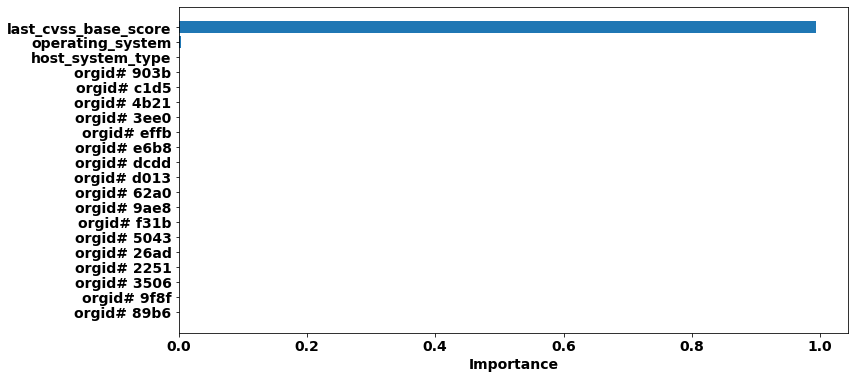

In [49]:
# Get feature importances from the model
feature_importance = model.feature_importances_

# If you have feature names
feature_names = X.columns

# Create a DataFrame to better visualize the feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the most important features
n_features_to_plot = 20  # choose the number of features to display
top_features = importance_df.iloc[:n_features_to_plot, :]

plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Importance'], align='center')
plt.xlabel("Importance", weight='bold', fontsize=14)

# Modify the tick label sizes and rotate x-axis labels
ax.set_xticks(records_per_month.index)  # Add this line
plt.xticks(fontsize=14, weight='bold')  # Change the value of fontsize to whatever you need and adjust rotation
plt.yticks(fontsize=14, weight='bold')  # Change the value of fontsize to whatever you need


plt.gca().invert_yaxis()
plt.show()


In [50]:
top_features['Importance']

2      0.993821
0      0.003788
1      0.000606
16     0.000606
11     0.000232
81     0.000213
5      0.000156
62     0.000115
4      0.000065
6      0.000056
110    0.000035
26     0.000031
3      0.000030
19     0.000029
14     0.000029
63     0.000022
115    0.000022
30     0.000017
109    0.000016
15     0.000016
Name: Importance, dtype: float64

### 2.2 Classificaion

#### Balance the Unbalanced Data
Only around 8% of the record considered to have at least one super critical vuln. 

In [51]:
# Drop features
unbalanced  = df_prep.drop([ 'index', 'ip_address_md5', 'created_on_date', 'cve', 'cvss_base_score', 'Heartbleed', 'Shellshock', 'Poodle', 'FREAK', 'Ghost', 'JASBUG', 'Logjam'], axis=1)

###### Resampling techniques:
Undersampling 

In [52]:
unbalanced_columns = unbalanced.columns.tolist()

# Import the necessary libraries
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Fit the RandomUnderSampler to the data and obtain the resampled data
X_resampled, y_resampled = rus.fit_resample(unbalanced.drop('super_vuln', axis=1), unbalanced['super_vuln'])

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=unbalanced_columns)
df_resampled['super_vuln'] = y_resampled



##### feature sets

In [53]:
# Feature sets for Classification models 
os_N_type = df_resampled[['operating_system', 'host_system_type']]
score = df_resampled[['last_cvss_base_score']]
orgid  = df_resampled.drop(['last_cvss_base_score', 'operating_system', 'host_system_type', 'last_cvss_base_score', 'super_vuln'], axis=1)
outcome_classi = df_resampled[['super_vuln']]

##### Libraries needed for regression models

In [55]:
from itertools import chain, combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


#### 2.2.1 Logistic Regression


Evaluating combination: os_N_type

Cross-validation scores (5-fold): [0.52340386 0.52705486 0.5242464  0.52022093 0.52256132]
Mean cross-validation score (5-fold): 0.5234974723834489
Accuracy: 0.5241153342070773
Precision: 0.5184083044982699
Recall: 0.6556673960612691
F1 Score: 0.5790144927536232
ROC AUC: 0.575480126462328

Evaluating combination: score

Cross-validation scores (5-fold): [0.60793859 0.61524059 0.61290021 0.60513013 0.6007302 ]
Mean cross-validation score (5-fold): 0.6083879423328964
Accuracy: 0.6072957623416338
Precision: 0.5781470550494033
Recall: 0.7887089715536105
F1 Score: 0.667209655325608
ROC AUC: 0.7021410114123375

Evaluating combination: orgid

Cross-validation scores (5-fold): [0.78299944 0.78917806 0.78590152 0.78599513 0.78814829]
Mean cross-validation score (5-fold): 0.7864444860513012
Accuracy: 0.789908256880734
Precision: 0.7563943574639591
Recall: 0.8541794310722101
F1 Score: 0.8023184116413861
ROC AUC: 0.8545810415296864

Evaluating combination: os_N_

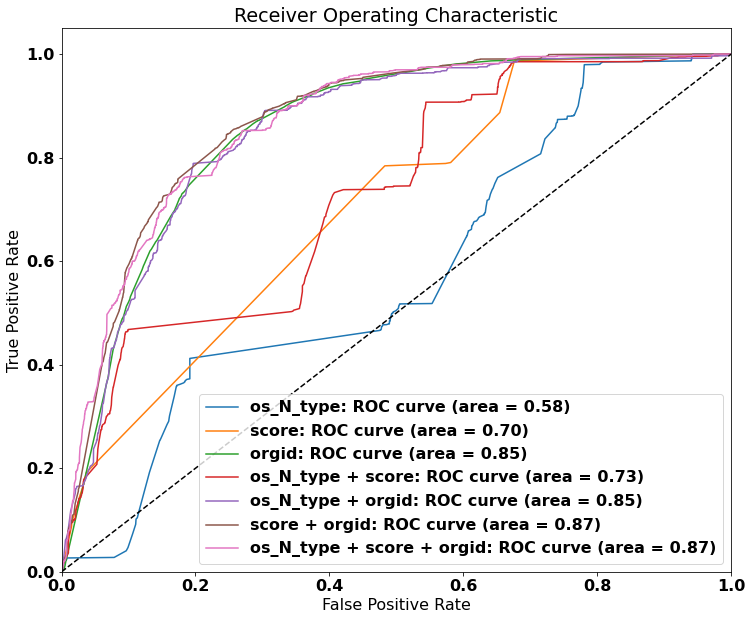

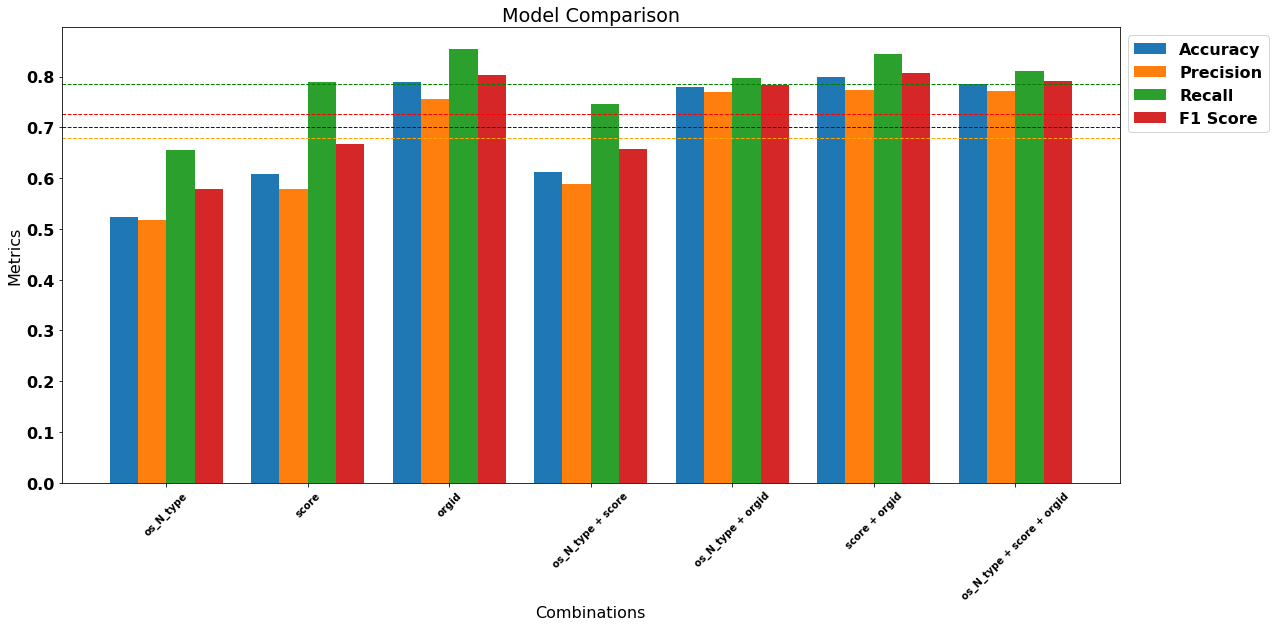

In [56]:

# Function to train and evaluate the model for a given set of features
def train_evaluate(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    classifier = LogisticRegression(random_state=1)
    
    # Add cross validation
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f"\nCross-validation scores (5-fold): {cv_scores}")
    print(f"Mean cross-validation score (5-fold): {np.mean(cv_scores)}")
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

# Combine the feature sets in all possible ways
feature_sets = [os_N_type, score, orgid]
feature_set_names = ['os_N_type', 'score', 'orgid']
combinations_list = list(chain(*map(lambda x: combinations(feature_sets, x), range(1, len(feature_sets) + 1))))

# Generate combination names
combination_names = []
for combination in combinations_list:
    name = ' + '.join([feature_set_names[i] for i, fs in enumerate(feature_sets) if any(id(fs) == id(c) for c in combination)])
    combination_names.append(name)

# Train and evaluate the model for each combination
results = []
roc_curves = []
for i, combination in enumerate(combinations_list):
    print(f"\nEvaluating combination: {combination_names[i]}")
    combined_features = pd.concat(combination, axis=1)
    accuracy, precision, recall, f1, fpr, tpr, roc_auc = train_evaluate(combined_features, outcome_classi)
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}")
    results.append((combination_names[i], accuracy, precision, recall, f1))
    roc_curves.append((fpr, tpr, roc_auc))

# Compare the results and plot them
results_df = pd.DataFrame(results, columns=['Combination', 'Accuracy', 'Precision', 'Recall', 'F1'])
print(results_df)

# Plot ROC curves for each combination
plt.figure(figsize=(12, 10))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f"{combination_names[i]}: ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the comparison
n_combinations = len(results_df)
bar_width = 0.2
index = np.arange(n_combinations)

fig, ax = plt.subplots(figsize=(18, 9))

ax.bar(index, results_df['Accuracy'], bar_width, label='Accuracy')
ax.bar(index + bar_width, results_df['Precision'], bar_width, label='Precision')
ax.bar(index + 2 * bar_width, results_df['Recall'], bar_width, label='Recall')
ax.bar(index + 3 * bar_width, results_df['F1'], bar_width, label='F1 Score')

ax.axhline(results_df['Accuracy'].mean(), color='b', linestyle='dashed', linewidth=1)
ax.axhline(results_df['Precision'].mean(), color='orange', linestyle='dashed', linewidth=1)
ax.axhline(results_df['Recall'].mean(), color='g', linestyle='dashed', linewidth=1)
ax.axhline(results_df['F1'].mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlabel('Combinations')
ax.set_ylabel('Metrics')
ax.set_title('Model Comparison')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(results_df['Combination'], rotation=45, fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


#### 2.2.2 Decision Tree


Evaluating combination: os_N_type

Cross-validation scores (5-fold): [0.81679461 0.81473507 0.81632653 0.81988392 0.8082756 ]
Mean cross-validation score (5-fold): 0.8152031454783748
Accuracy: 0.8206640454346876
Precision: 0.8027796161482462
Recall: 0.8493654266958425
F1 Score: 0.8254157274699102
ROC AUC: 0.8846204517411473
Mean CV Score: 0.8152031454783748

Evaluating combination: score

Cross-validation scores (5-fold): [0.70005617 0.7026774  0.70979217 0.70033702 0.6978094 ]
Mean cross-validation score (5-fold): 0.7021344317543531
Accuracy: 0.7004805591961555
Precision: 0.6283354867704062
Recall: 0.9789934354485776
F1 Score: 0.765414357079313
ROC AUC: 0.7574466213888525
Mean CV Score: 0.7021344317543531

Evaluating combination: orgid

Cross-validation scores (5-fold): [0.78496536 0.79198652 0.78786744 0.78833552 0.7900206 ]
Mean cross-validation score (5-fold): 0.7886350870623479
Accuracy: 0.7912188728702491
Precision: 0.7552619449992318
Recall: 0.8605689277899343
F1 Score: 0.80448

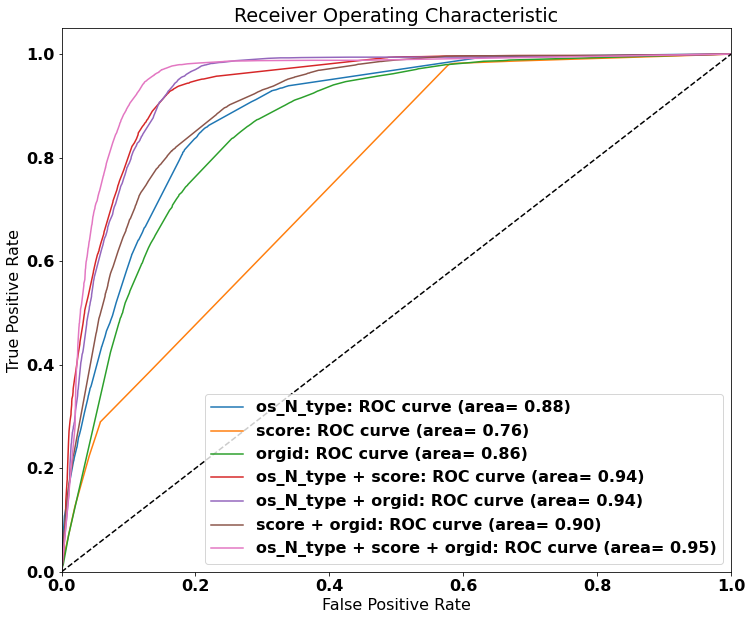

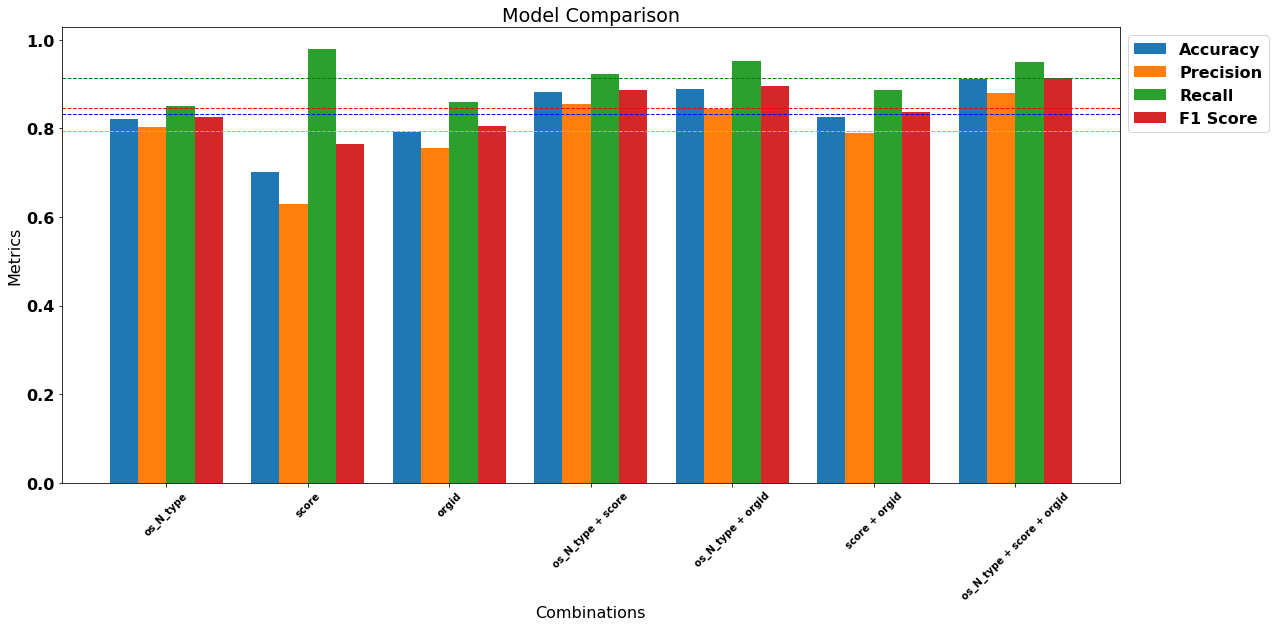

In [57]:
from sklearn.tree import DecisionTreeClassifier

# Function to train and evaluate the model for a given set of features
def train_evaluate(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    classifier = DecisionTreeClassifier(random_state=1)
    
    # Add cross validation
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f"\nCross-validation scores (5-fold): {cv_scores}")
    mean_cv_score = np.mean(cv_scores)
    print(f"Mean cross-validation score (5-fold): {mean_cv_score}")
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return accuracy, precision, recall, f1, fpr, tpr, roc_auc, mean_cv_score

# Combine the feature sets in all possible ways
feature_sets = [os_N_type, score, orgid]
feature_set_names = ['os_N_type', 'score', 'orgid']
combinations_list = list(chain(*map(lambda x: combinations(feature_sets, x), range(1, len(feature_sets) + 1))))

# Generate combination names
combination_names = []
for combination in combinations_list:
    name = ' + '.join([feature_set_names[i] for i, fs in enumerate(feature_sets) if any(id(fs) == id(c) for c in combination)])
    combination_names.append(name)

# Train and evaluate the model for each combination
results = []
roc_curves = []
for i, combination in enumerate(combinations_list):
    print(f"\nEvaluating combination: {combination_names[i]}")
    combined_features = pd.concat(combination, axis=1)
    accuracy, precision, recall, f1, fpr, tpr, roc_auc, mean_cv_score = train_evaluate(combined_features, outcome_classi)
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}\nMean CV Score: {mean_cv_score}")
    results.append((combination_names[i], accuracy, precision, recall, f1, mean_cv_score))
    roc_curves.append((fpr, tpr, roc_auc))

# Compare the results and plot them
results_df = pd.DataFrame(results, columns=['Combination', 'Accuracy', 'Precision', 'Recall', 'F1', 'Mean CV Score'])
print(results_df)

# Plot ROC curves for each combination
plt.figure(figsize=(12, 10))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f"{combination_names[i]}: ROC curve (area= {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
# Plot the comparison
n_combinations = len(results_df)
bar_width = 0.2
index = np.arange(n_combinations)

fig, ax = plt.subplots(figsize=(18, 9))

ax.bar(index, results_df['Accuracy'], bar_width, label='Accuracy')
ax.bar(index + bar_width, results_df['Precision'], bar_width, label='Precision')
ax.bar(index + 2 * bar_width, results_df['Recall'], bar_width, label='Recall')
ax.bar(index + 3 * bar_width, results_df['F1'], bar_width, label='F1 Score')

ax.axhline(results_df['Accuracy'].mean(), color='b', linestyle='dashed', linewidth=1)
ax.axhline(results_df['Precision'].mean(), color='orange', linestyle='dashed', linewidth=1)
ax.axhline(results_df['Recall'].mean(), color='g', linestyle='dashed', linewidth=1)
ax.axhline(results_df['F1'].mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlabel('Combinations')
ax.set_ylabel('Metrics')
ax.set_title('Model Comparison')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(results_df['Combination'], rotation=45, fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

#### 2.2.3 Random Forest


Evaluating combination: os_N_type

Cross-validation scores (5-fold): [0.81670099 0.81464145 0.81913499 0.82025838 0.80855645]
Mean cross-validation score (5-fold): 0.8158584534731324
Accuracy: 0.8211446046308432
Precision: 0.8028087567121024
Recall: 0.8505908096280087
F1 Score: 0.8260093497662558
ROC AUC: 0.8848113705397742
Mean CV Score: 0.8158584534731324

Evaluating combination: score

Cross-validation scores (5-fold): [0.70005617 0.7026774  0.70979217 0.70033702 0.6978094 ]
Mean cross-validation score (5-fold): 0.7021344317543531
Accuracy: 0.7004805591961555
Precision: 0.6283354867704062
Recall: 0.9789934354485776
F1 Score: 0.765414357079313
ROC AUC: 0.7574466213888525
Mean CV Score: 0.7021344317543531

Evaluating combination: orgid

Cross-validation scores (5-fold): [0.7845909  0.79179929 0.78777383 0.78805467 0.79030144]
Mean cross-validation score (5-fold): 0.7885040254633964
Accuracy: 0.7908256880733945
Precision: 0.7564726794960971
Recall: 0.8567177242888403
F1 Score: 0.80348

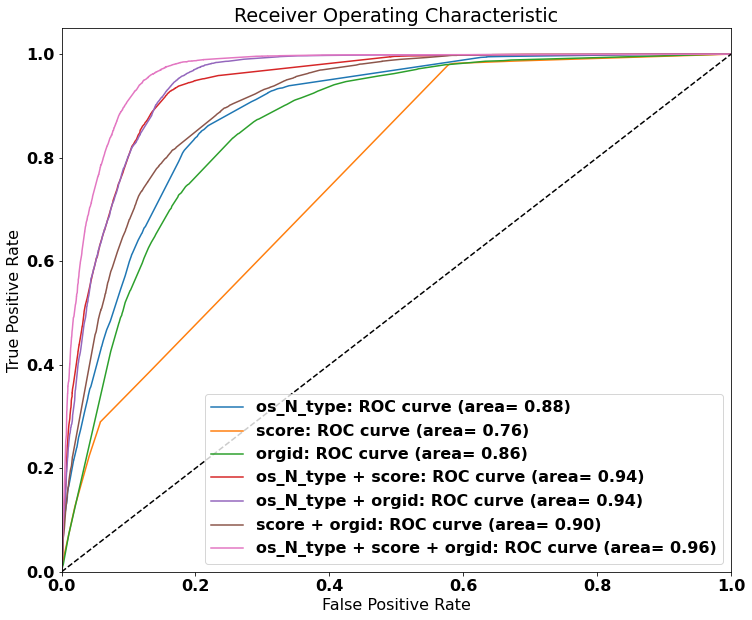

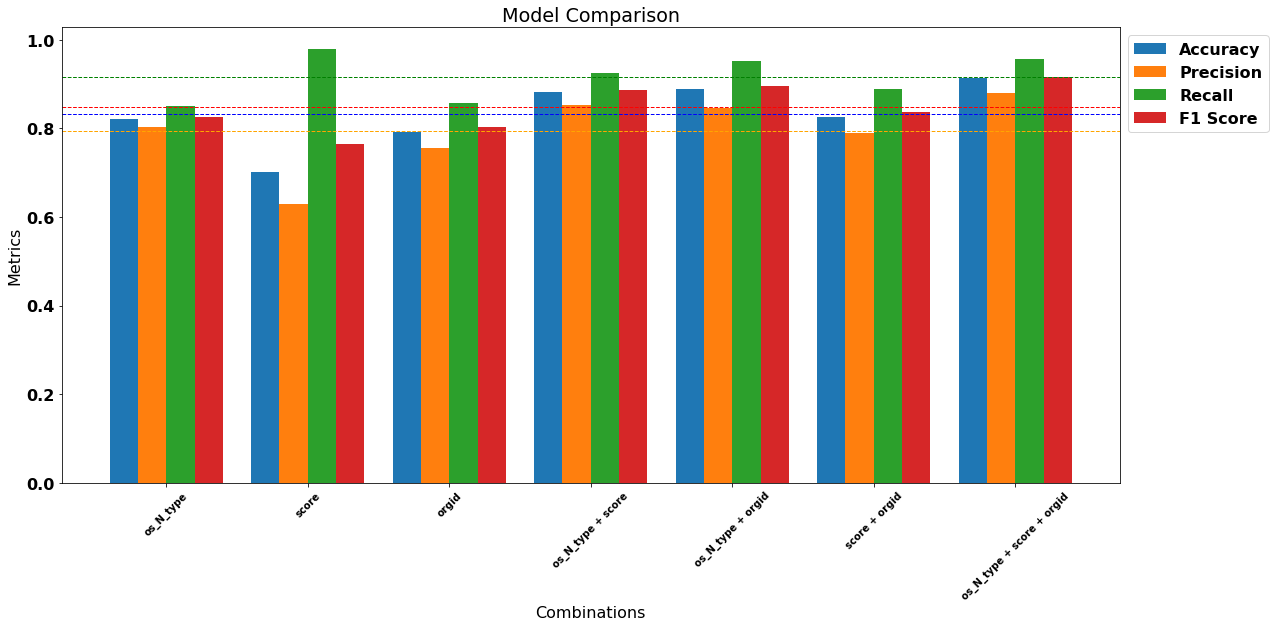

In [58]:
import pandas as pd
import numpy as np
from itertools import chain, combinations
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Function to train and evaluate the model for a given set of features
def train_evaluate(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    classifier = RandomForestClassifier(random_state=1)
    
    # Add cross validation
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f"\nCross-validation scores (5-fold): {cv_scores}")
    mean_cv_score = np.mean(cv_scores)
    print(f"Mean cross-validation score (5-fold): {mean_cv_score}")
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return accuracy, precision, recall, f1, fpr, tpr, roc_auc, mean_cv_score

# Combine the feature sets in all possible ways
feature_sets = [os_N_type, score, orgid]
feature_set_names = ['os_N_type', 'score', 'orgid']
combinations_list = list(chain(*map(lambda x: combinations(feature_sets, x), range(1, len(feature_sets) + 1))))

# Generate combination names
combination_names = []
for combination in combinations_list:
    name = ' + '.join([feature_set_names[i] for i, fs in enumerate(feature_sets) if any(id(fs) == id(c) for c in combination)])
    combination_names.append(name)

# Train and evaluate the model for each combination
results = []
roc_curves = []
for i, combination in enumerate(combinations_list):
    print(f"\nEvaluating combination: {combination_names[i]}")
    combined_features = pd.concat(combination, axis=1)
    accuracy, precision, recall, f1, fpr, tpr, roc_auc, mean_cv_score = train_evaluate(combined_features, outcome_classi)
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}\nMean CV Score: {mean_cv_score}")
    results.append((combination_names[i], accuracy, precision, recall, f1, mean_cv_score))
    roc_curves.append((fpr, tpr, roc_auc))

# Compare the results and plot them
results_df = pd.DataFrame(results, columns=['Combination', 'Accuracy', 'Precision', 'Recall', 'F1', 'Mean CV Score'])
print(results_df)

# Plot ROC curves for each combination
plt.figure(figsize=(12, 10))
for i, (fpr, tpr, roc_auc) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f"{combination_names[i]}: ROC curve (area= {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
# Plot the comparison
n_combinations = len(results_df)
bar_width = 0.2
index = np.arange(n_combinations)

fig, ax = plt.subplots(figsize=(18, 9))

ax.bar(index, results_df['Accuracy'], bar_width, label='Accuracy')
ax.bar(index + bar_width, results_df['Precision'], bar_width, label='Precision')
ax.bar(index + 2 * bar_width, results_df['Recall'], bar_width, label='Recall')
ax.bar(index + 3 * bar_width, results_df['F1'], bar_width, label='F1 Score')

ax.axhline(results_df['Accuracy'].mean(), color='b', linestyle='dashed', linewidth=1)
ax.axhline(results_df['Precision'].mean(), color='orange', linestyle='dashed', linewidth=1)
ax.axhline(results_df['Recall'].mean(), color='g', linestyle='dashed', linewidth=1)
ax.axhline(results_df['F1'].mean(), color='r', linestyle='dashed', linewidth=1)

ax.set_xlabel('Combinations')
ax.set_ylabel('Metrics')
ax.set_title('Model Comparison')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(results_df['Combination'], rotation=45, fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

##### Confusion  matrix for RF model

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     11465
           1       0.88      0.96      0.92     11425

    accuracy                           0.91     22890
   macro avg       0.92      0.91      0.91     22890
weighted avg       0.92      0.91      0.91     22890



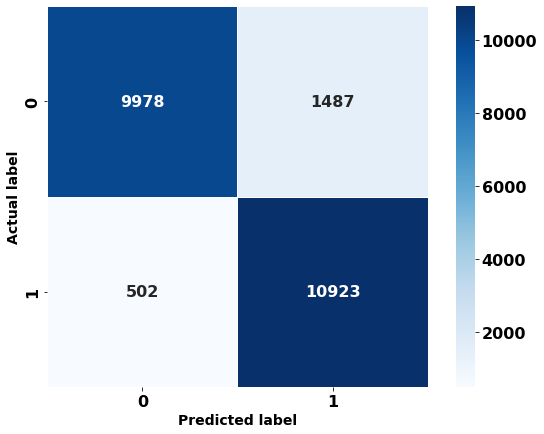

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(combined_features, outcome_classi, test_size=0.3, random_state=1)
classifier = RandomForestClassifier(random_state=1)

# Fit the model on the training data
classifier.fit(X_train, y_train)

# After classifier.predict in your function
y_pred = classifier.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Generate classification report
report = classification_report(y_test, y_pred)

print(report)


# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label', fontsize = 14, weight = 'bold');
plt.xlabel('Predicted label', fontsize = 14, weight = 'bold');
plt.show()


##### Feature Importance for RF model

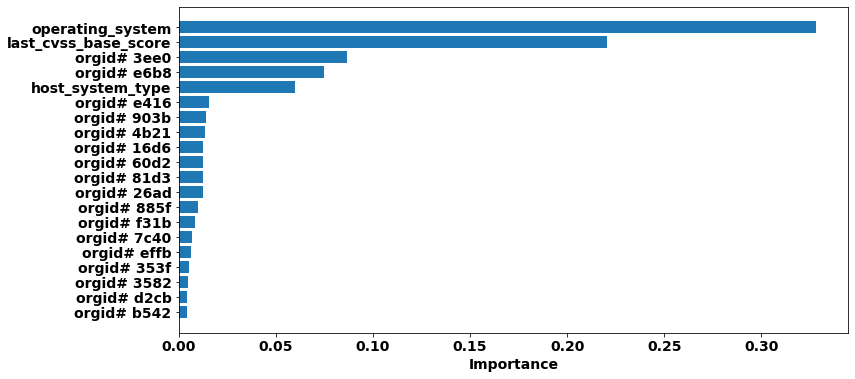

In [62]:
def train_evaluate(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    classifier = RandomForestClassifier(random_state=1)
    classifier.fit(X_train, y_train)
    feature_importance = classifier.feature_importances_
    return feature_importance

combined_features = pd.concat([os_N_type, score, orgid], axis=1)
feature_importance = train_evaluate(combined_features, outcome_classi)

# Plot the first 20 features' importance
n_features_to_plot = 20
sorted_idx = np.argsort(feature_importance)[-n_features_to_plot:]

plt.figure(figsize=(12, 6))
plt.barh(range(n_features_to_plot), feature_importance[sorted_idx])
plt.yticks(range(n_features_to_plot), combined_features.columns[sorted_idx], fontsize=14, weight='bold')
plt.xlabel('Importance', fontsize=14, weight='bold')
plt.xticks(fontsize=14, weight='bold')

plt.show()

In [63]:
# We already have feature_importance and sorted_idx from your previous code.

# Select the top 5 features
top_n = 5
sorted_idx_top_n = sorted_idx[-top_n:]

# Print out the feature importance for the top 5 features
print("Top 5 Features based on Importance:\n")
for i in range(1, top_n+1):
    feature_name = combined_features.columns[sorted_idx_top_n[-i]]
    importance = feature_importance[sorted_idx_top_n[-i]]
    print(f"{i}. Feature: {feature_name}, Importance: {importance}")

Top 5 Features based on Importance:

1. Feature: operating_system, Importance: 0.3282362586015073
2. Feature: last_cvss_base_score, Importance: 0.22053538114265225
3. Feature: orgid# 3ee0, Importance: 0.08666047048363149
4. Feature: orgid# e6b8, Importance: 0.07483893253801792
5. Feature: host_system_type, Importance: 0.059997644893561485


##### ROC Comparison - Three different algorithms 


Evaluating model: Logistic Regression
Accuracy: 0.7862822193097423
Precision: 0.7723218007503126
Recall: 0.8108533916849016
F1 Score: 0.7911187019641333
ROC AUC: 0.8658337190249842

Evaluating model: Decision Tree
Accuracy: 0.9110091743119266
Precision: 0.8808828302499189
Recall: 0.9501969365426696
F1 Score: 0.9142279674933682
ROC AUC: 0.9498001318826874

Evaluating model: Random Forest
Accuracy: 0.9131061598951508
Precision: 0.8801772763900081
Recall: 0.9560612691466083
F1 Score: 0.916551290119572
ROC AUC: 0.9626855628537427


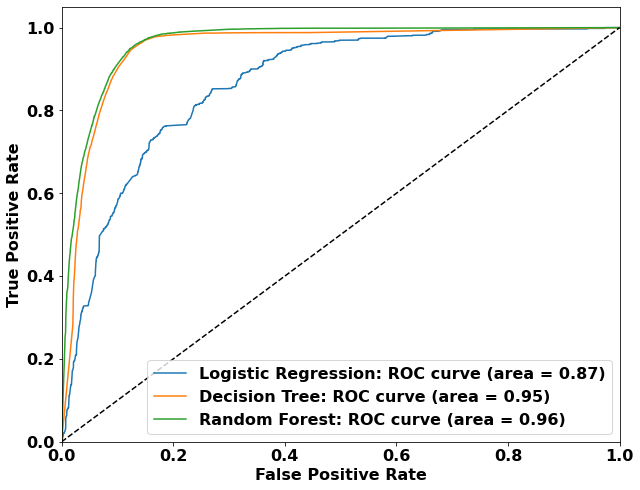

In [64]:

# Assume df is your DataFrame and it has 'os_N_type', 'score', 'orgid' as columns and 'outcome_classi' as target
features = pd.concat([os_N_type, score, orgid], axis=1)
target = outcome_classi

# Function to train and evaluate a given model
def train_evaluate(model, features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

# Define the models
models = [
    ("Logistic Regression", LogisticRegression(random_state=1)),
    ("Decision Tree", DecisionTreeClassifier(random_state=1)),
    ("Random Forest", RandomForestClassifier(random_state=1))
]

plt.figure(figsize=(10, 8))

# Adjusting the font size and style of the plot
plt.rcParams['font.size'] = '16'
plt.rcParams['font.weight'] = 'bold'

# Train and evaluate each model
for name, model in models:
    print(f"\nEvaluating model: {name}")
    accuracy, precision, recall, f1, fpr, tpr, roc_auc = train_evaluate(model, features, target)
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nROC AUC: {roc_auc}")
    plt.plot(fpr, tpr, label=f"{name}: ROC curve (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 16, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 16, weight = 'bold')
plt.legend(loc="lower right")
plt.show()
